In [1]:
import sys
sys.path.append('../..')

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from dataset.cotter_dataset import CotterData
from model.ml.lstm_ann import LSTMWithANN

In [3]:
train_dates = (dt.datetime(1990, 1, 1), dt.datetime(2004, 12, 31))
val_dates = (dt.datetime(2005, 1, 1), dt.datetime(2014, 12, 31))

ds = CotterData('../../dataset/dataconfig.yml', train_dates=train_dates, val_dates=val_dates, keep_z=True, create_seq=True)

In [4]:
train_dl = ds.get_dataloader(train=True)
val_dl = ds.get_dataloader(train=False)
X, z, y = next(iter(train_dl))

In [5]:
X.shape, z.shape, y.shape

(torch.Size([64, 5, 3]), torch.Size([64, 2]), torch.Size([64, 1]))

In [6]:
model = LSTMWithANN(
    input_dim=3,
    hidden_dim=16,
    output_dim=1,
    n_layers=1
)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
early_stopper = EarlyStopper(patience=10, min_delta=0.05)

In [23]:
N = 300

pbar = tqdm(range(N))

for epoch in pbar:

    epoch_loss = 0.
    model.train()

    for i, (X, z, y) in enumerate(train_dl):

        opt.zero_grad()

        y_hat = model(X, z)

        loss = loss_fn(y, y_hat)
        epoch_loss += loss

        loss.backward()

        opt.step()

    epoch_val_loss = 0.
    model.eval()

    for j, (X_val, z_val, y_val) in enumerate(val_dl):
        y_val_hat = model(X_val, z_val)
        epoch_val_loss += loss_fn(y_val, y_val_hat)
    
    pbar.set_description(f"Epoch {epoch+1} loss: {epoch_loss.detach().numpy()/(i+1):.4f} val_loss: {epoch_val_loss.detach().numpy()/(j+1):.4f}")


    if early_stopper.early_stop(epoch_val_loss):
        break

    

Epoch 27 loss: 0.2268 val_loss: 0.7312:   9%|▊         | 26/300 [00:08<01:25,  3.21it/s]


In [24]:
WINDOW_SIZE = 7

In [25]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

def evaluate(model, dl):

    
    y_list = []
    y_hat_list = []

    for j, (X, z, y) in enumerate(dl):
        y_hat = model(X, z)

        y_list.append(y)
        y_hat_list.append(y_hat)

    flow = torch.concat(y_list, dim=0).detach().numpy()
    flow_pred = torch.concat(y_hat_list, dim=0).detach().numpy()

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")


    # Post processing
    flow_pred = ds.y_scaler.inverse_transform(flow_pred)
    flow = ds.y_scaler.inverse_transform(flow)


    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(flow, color='black', label='obs', alpha=1.0)
    ax.plot(flow_pred, color='red', label='pred', alpha=0.7)
    # ax.plot(dates, prcp.detach().numpy(), 'g--', label='precip', alpha=0.45)
    # ax.plot(dates, et.detach().numpy(), 'y--', label='etp', alpha=0.45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

    return flow_pred, flow

NSE: 0.396
Normalized NSE: 0.624


(array([[45.104614],
        [43.5598  ],
        [64.44762 ],
        ...,
        [51.012924],
        [38.61977 ],
        [91.26643 ]], dtype=float32),
 array([[74.8224  ],
        [67.9104  ],
        [62.5536  ],
        ...,
        [17.712   ],
        [17.712   ],
        [16.156801]], dtype=float32))

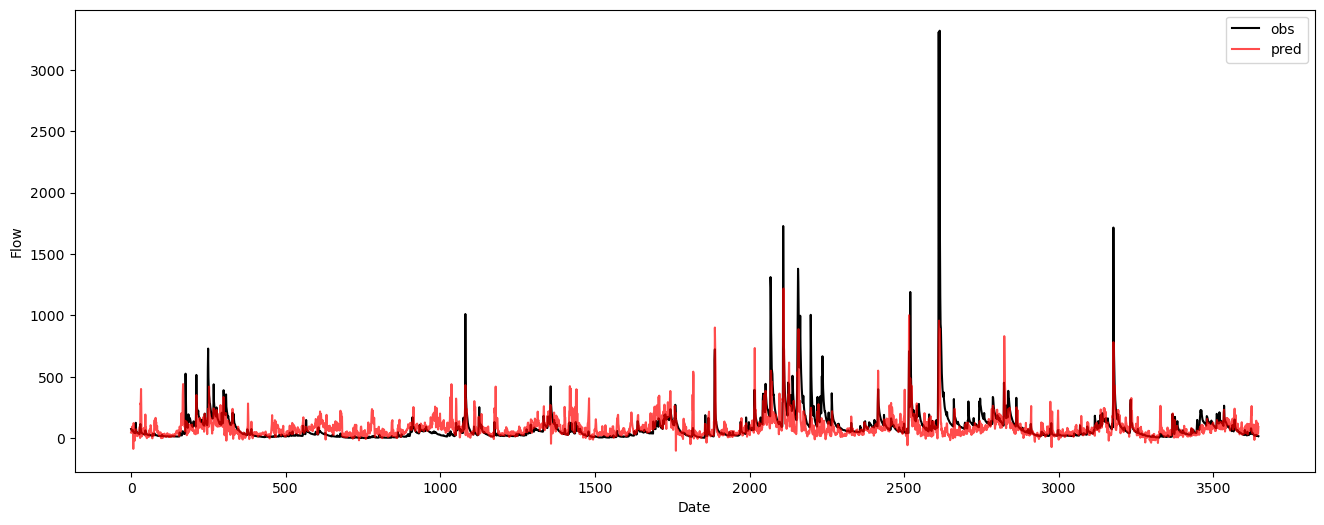

In [26]:
evaluate(model, ds.get_dataloader(train=False, shuffle=False))